In [11]:
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
# Load data
df = pd.read_csv('merged_data_clean.csv', parse_dates=['Datum'])

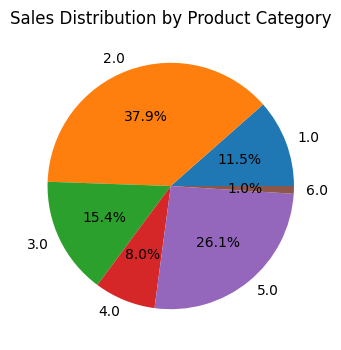

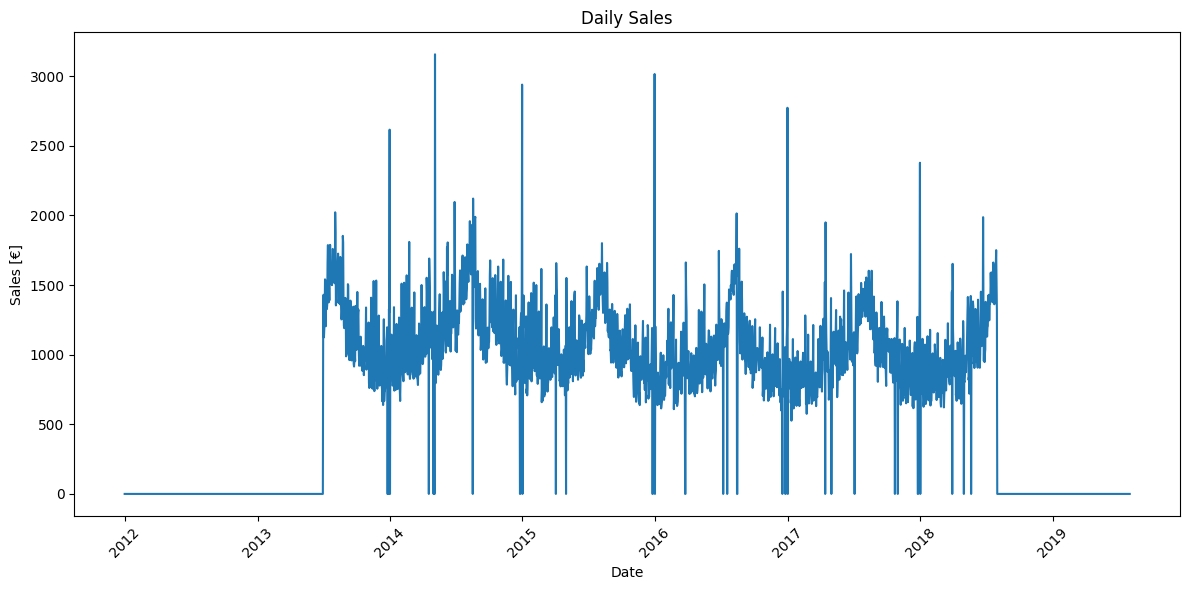

In [15]:
# PIE CHART - Sales distribution by product category
plt.figure(figsize=(4, 4))
sales_by_category = df.groupby('Warengruppe')['Umsatz'].sum()
plt.pie(sales_by_category.values, labels=sales_by_category.index, autopct='%1.1f%%')
plt.title('Sales Distribution by Product Category')
#plt.savefig('pie_chart_product_categories.png')
plt.show()

# Time Series - Daily Sales
plt.figure(figsize=(12, 6))
daily_sales = df.groupby('Datum')['Umsatz'].sum()
plt.plot(daily_sales.index, daily_sales.values)
plt.title('Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales [€]')
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig('zeitreihe_umsatz.png')
plt.show()


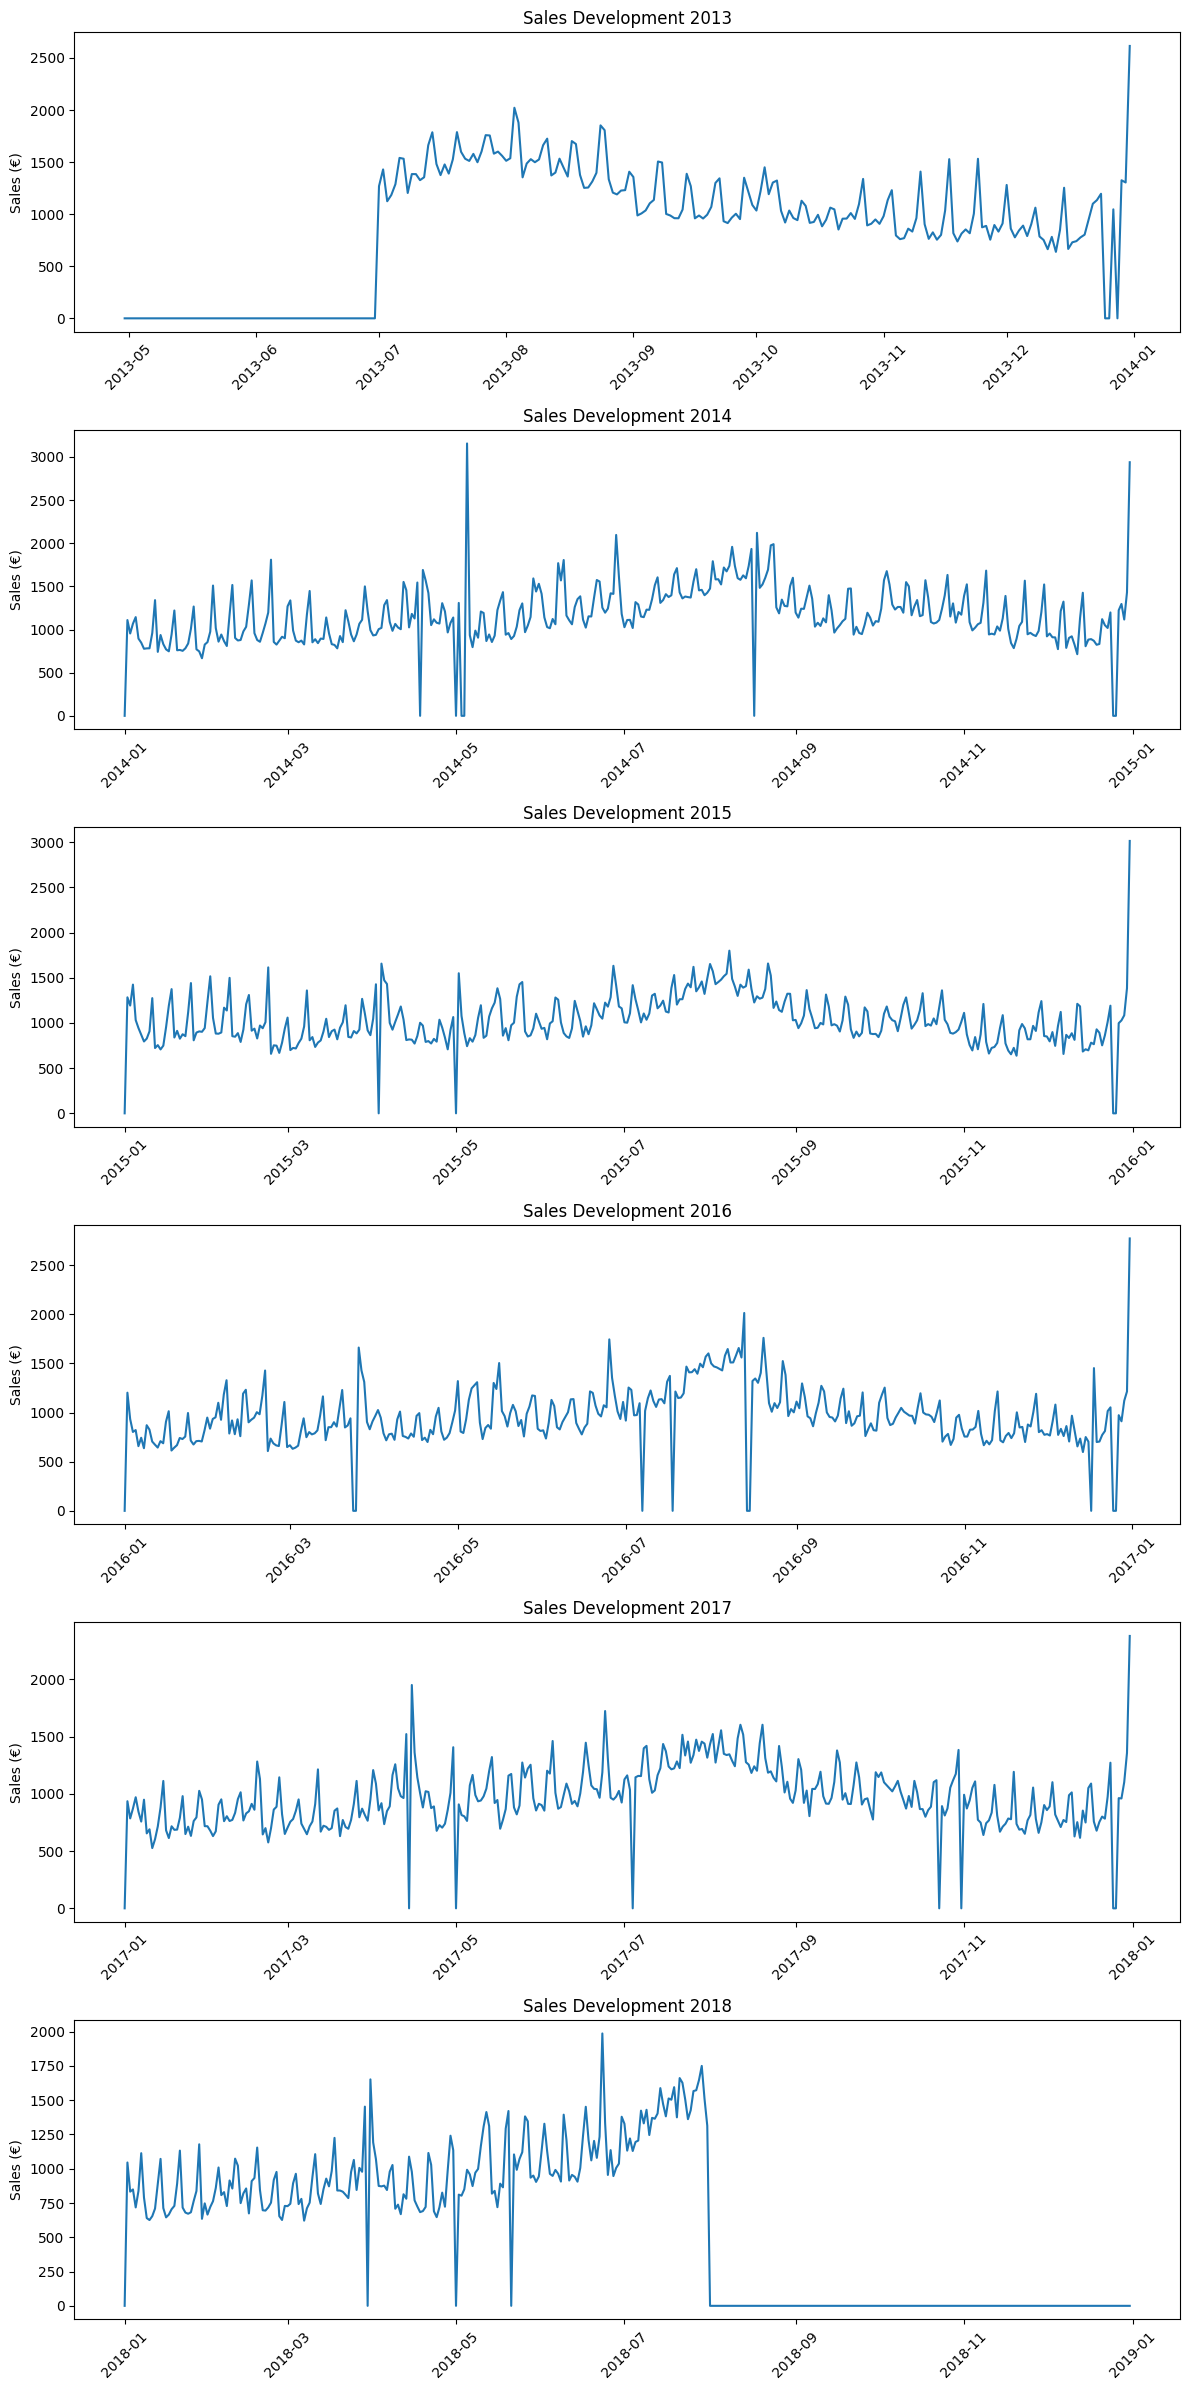

In [14]:
# TIME SERIES CHART - Daily sales by years
daily_sales = df.groupby('Datum')['Umsatz'].sum().reset_index()
daily_sales['Year'] = daily_sales['Datum'].dt.year

# Remove years 2012 and 2019
daily_sales = daily_sales[~daily_sales['Year'].isin([2012, 2019])]

# Get unique years
years = sorted(daily_sales['Year'].unique())
num_years = len(years)

# Create subplots
fig, axes = plt.subplots(num_years, 1, figsize=(12, 4*num_years))
if num_years == 1:
    axes = [axes]  # For case when only one year is present

for i, year in enumerate(years):
    year_data = daily_sales[daily_sales['Year'] == year]
    axes[i].plot(year_data['Datum'], year_data['Umsatz'])
    axes[i].set_title(f'Sales Development {year}')
    axes[i].set_ylabel('Sales (€)')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
#plt.savefig('time_series_sales_by_years.png')
plt.show()